In [3]:
# imports
import sys
sys.path.append( '..' )

from FIA import *
from ML.ML4com import *
from plot import *

In [ ]:
run = "ML/latent"
run_dir = f"/mnt/d/runs/{run}"
report_dir = f"/mnt/d/reports/{run}"

## Mock data

In [3]:
conf_matrices = np.array([[[10, 1], [9, 2]], [[5, 5], [6, 4]], [[0, 0], [0, 1]]])
accuracies = np.array([[1.0, 0.98, 0.77, 0.82, 0.99], [1.0, 0.98, 0.77, 1.0, 0.69], [0.1, 0.23, 0.98, 0.27, 0.74]])

In [2]:
# PLOTTING
def plot_cv_confmat(ys, target_labels, accuracies, confusion_matrices, outdir, name):
    """
    Plot heatmap of confusion matrix
    """
    warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect*")
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 8))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])          # type: ignore
    for i, ax in enumerate(axs.flat):
        sns.heatmap(confusion_matrices[i], 
                    vmin=0, vmax=len(ys), annot=True, ax=ax, 
                    cbar=i == 0, cbar_ax=None if i else cbar_ax)
        ax.set_title(f'{target_labels[i]}, Accuracy: {round(accuracies[i], 5)}')
        ax.axis('off')
    fig.tight_layout(rect=[0, 0, .9, 1])                # type: ignore
    plt.savefig(os.path.join(outdir, f"{name}.png"))
    plt.close()

## Plots

### Heatmaps

<Axes: >

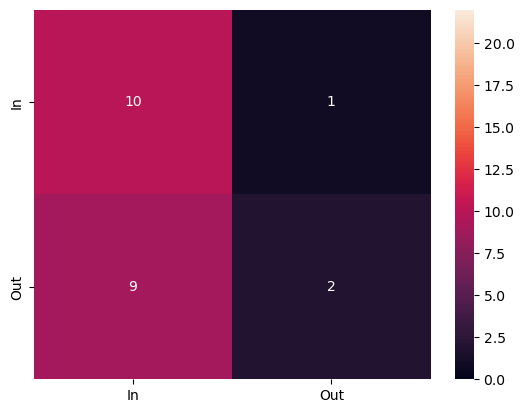

In [4]:
# Confusion matrix
plot_df = pd.DataFrame(conf_matrices[0], columns=["In", "Out"], index=["In", "Out"])
sns.heatmap(plot_df, vmin=0, vmax=np.sum(conf_matrices[0]), annot=True)

<Axes: xlabel='Cross-Validation run', ylabel='Organisms'>

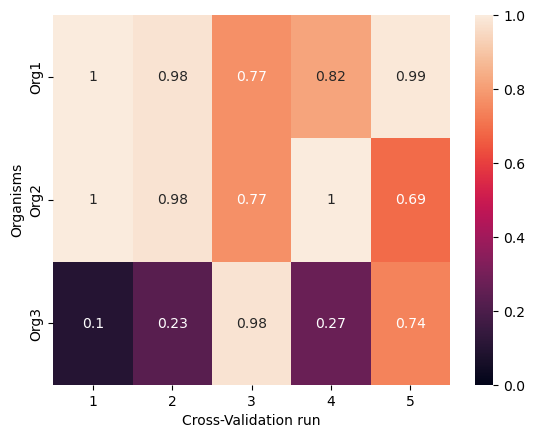

In [5]:
# Accuracy CV matrix
plot_df = pd.DataFrame(accuracies, columns=[1, 2, 3, 4, 5], index=["Org1", "Org2", "Org3"])
plot_df.index.name = "Organisms"
plot_df.columns.name = "Cross-Validation run"
sns.heatmap(plot_df, vmin=0, vmax=1.0, annot=True)

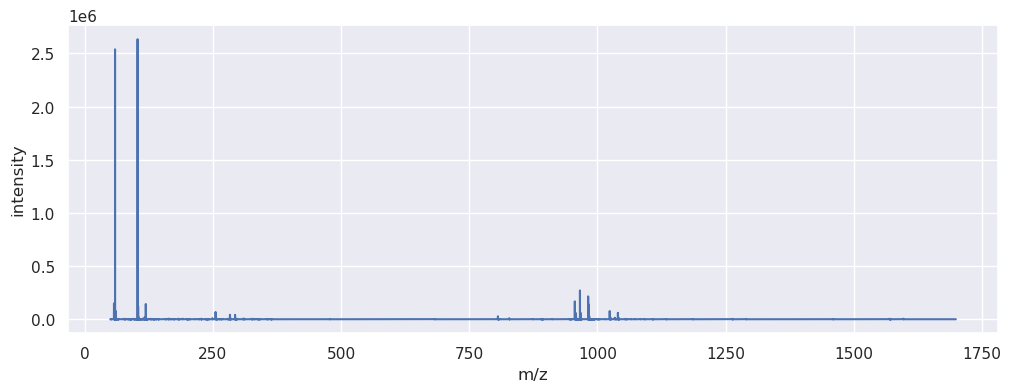

In [6]:
exp = load_experiment("../../data/comm8_self/converted/msAV206_P3A1_neg.mzML")
sns.set_theme(rc={"figure.figsize":(12, 4)})
ax = sns.lineplot(pd.DataFrame(np.array(exp[0].get_peaks()).T, columns=["m/z", "intensity"]), x="m/z", y="intensity")